In [102]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('data_cleaned.csv')
data.head()



,gender,height,weight,cholesterol,gluc,smoke,alco,active,cardio,age_years,bp_category_encoded
0,1,0.463125,-0.873002,1,1,0,0,1,0,-0.412905,2
1,0,-1.107092,0.933963,3,1,0,0,1,1,0.325344,3
2,0,0.070571,-0.715875,3,1,0,0,0,1,-0.265255,2
3,1,0.593977,0.698272,1,1,0,0,1,1,-0.708204,3
4,0,-1.107092,-1.344384,1,1,0,0,0,0,-0.855854,0


Data cleaning

In [103]:
data.head()

,gender,height,weight,cholesterol,gluc,smoke,alco,active,cardio,age_years,bp_category_encoded
0,1,0.463125,-0.873002,1,1,0,0,1,0,-0.412905,2
1,0,-1.107092,0.933963,3,1,0,0,1,1,0.325344,3
2,0,0.070571,-0.715875,3,1,0,0,0,1,-0.265255,2
3,1,0.593977,0.698272,1,1,0,0,1,1,-0.708204,3
4,0,-1.107092,-1.344384,1,1,0,0,0,0,-0.855854,0


Splitting data

In [136]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = data.drop(columns=['cardio'])  # Drop the target column
y = data['cardio']  # Keep only the target column

# 60/20/20 train/val/test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify = y, random_state=4240)  # 60% train, 40% temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify = y_temp, random_state=4240)  # 20% val, 20% test

print("Train Shape:", X_train.shape)
print("Validation Shape:", X_val.shape)
print("Test Shape:", X_test.shape)

Train Shape: (39411, 10)
Validation Shape: (13137, 10)
Test Shape: (13138, 10)


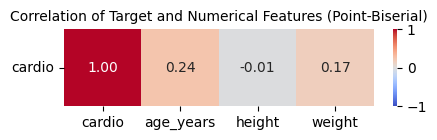

In [248]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr

# List of numerical features, including 'cardio'
numerical_features = ['cardio', 'age_years', 'height', 'weight']

# Compute the correlation matrix using the default (Pearson) method
correlation_matrix = data[numerical_features].corr()

# Overwrite the correlations for 'cardio' vs each other numerical variable with point-biserial coefficients
for feature in numerical_features:
    if feature != 'cardio':
        pb_corr = pointbiserialr(data['cardio'], data[feature])[0]
        correlation_matrix.loc['cardio', feature] = pb_corr
        correlation_matrix.loc[feature, 'cardio'] = pb_corr

cardio_corr = correlation_matrix.loc[['cardio']]

# Plot the updated correlation matrix
plt.figure(figsize=(5, 1))
ax = sns.heatmap(cardio_corr, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation of Target and Numerical Features (Point-Biserial)", fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.show()


# Manual Selection
Numerical Drop Height
Categorical drop gender smoke alco

In [283]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import statsmodels.api as sm


data_manual_model = data.drop(columns=['height', 'gender', 'smoke', 'alco'])

# Train the logistic regression model using scikit-learn on the training set
manual_model = LogisticRegression()
manual_model.fit(X_train, y_train)

# Evaluate on the validation set
manual_y_val_pred = manual_model.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, manual_y_val_pred))
print("\nValidation Classification Report:")
print(classification_report(y_val, manual_y_val_pred))

# Evaluate on the test set
manual_y_test_pred = manual_model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, manual_y_test_pred))
print("\nTest Classification Report:")
print(classification_report(y_test, manual_y_test_pred))

# ----- Statsmodels: ANOVA-like table and Odds Ratios on Test Set -----

X_test_manual = X_test.drop(columns=['height', 'gender', 'smoke', 'alco']).reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)

# Add a constant (intercept) term to the test set predictors
X_test_manual_df = sm.add_constant(X_test_manual)

# Fit logistic regression using statsmodels on the test set
logit_model_test = sm.Logit(y_test_reset, X_test_manual_df)
result_test = logit_model_test.fit()

# Print the detailed summary for the test set (ANOVA-like table)
print("\n=== Test Set ANOVA Table (Manual Selection) ===")
print(result_test.summary())

# Calculate and print the Odds Ratios for the test set
odds_ratios_test = pd.Series(np.exp(result_test.params), index=X_test_manual_df.columns)
print("\n=== Test Set Odds Ratios ===")
print(odds_ratios_test)


Validation Accuracy: 0.6911775900129405

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.71      0.70      6772
           1       0.69      0.67      0.68      6365

    accuracy                           0.69     13137
   macro avg       0.69      0.69      0.69     13137
weighted avg       0.69      0.69      0.69     13137

Test Accuracy: 0.6848835439184047

Test Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.70      0.70      6797
           1       0.67      0.67      0.67      6341

    accuracy                           0.68     13138
   macro avg       0.68      0.68      0.68     13138
weighted avg       0.68      0.68      0.68     13138

Optimization terminated successfully.
         Current function value: 0.602593
         Iterations 6

=== Test Set ANOVA Table (Manual Selection) ===
                           Logit Regression Results      

ROC curve

0.7426387612167925


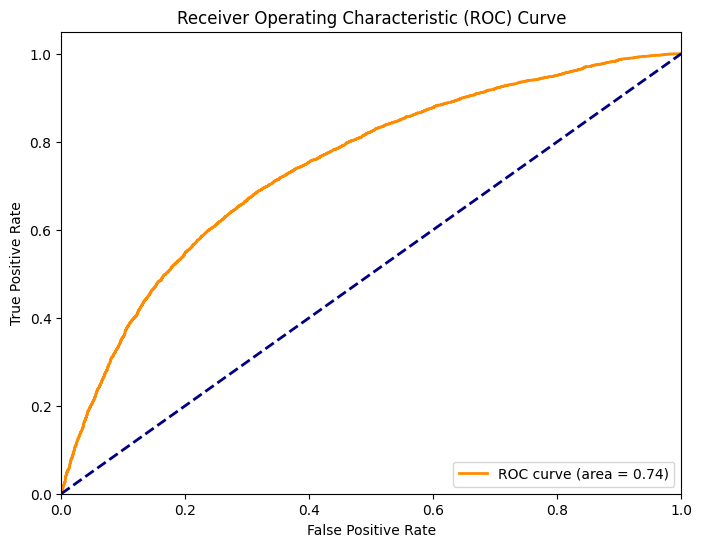

In [253]:
from sklearn.metrics import roc_curve, auc
# ---- Plot ROC Curve for the scikit-learn Logistic Regression Model ----

# Get predicted probabilities for the positive class using the scikit-learn model
y_proba = manual_model.predict_proba(X_test)[:, 1]

# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Calculate the Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)
print(roc_auc)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Forward/backward selection

In [254]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Assume X_train, X_val, X_test, y_train, y_val, y_test are already defined
# and that X is a DataFrame with feature names

# Initialize Logistic Regression Model
lr = LogisticRegression(solver='liblinear')

# Perform floating feature selection
# forward=True and floating=True enable sequential forward floating selection (SFFS)
sfs = SFS(lr, 
          k_features=6,             # desired number of features (adjust as needed)
          forward=True,             # start with forward selection
          floating=True,            # allow backward steps (floating)
          scoring='accuracy',       # use accuracy as the metric
          cv=5)                     # 5-fold cross-validation

# Fit SFS on training data
sfs.fit(X_train, y_train)

# Get the selected feature names
selected_features = list(sfs.k_feature_names_)
print("Selected Features (Floating SFS):", selected_features)

# Subset the datasets based on the selected features
X_train_sel = X_train[selected_features].reset_index(drop=True)
X_val_sel = X_val[selected_features].reset_index(drop=True)
X_test_sel = X_test[selected_features].reset_index(drop=True)
y_train_reset = y_train.reset_index(drop=True)
y_val_reset = y_val.reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)

# Train logistic regression model using the selected features
lr.fit(X_train_sel, y_train_reset)

# Evaluate on the validation set
y_val_pred = lr.predict(X_val_sel)
print("\nValidation Accuracy:", accuracy_score(y_val_reset, y_val_pred))
print("\nValidation Classification Report:")
print(classification_report(y_val_reset, y_val_pred))

# Evaluate on the test set
y_test_pred = lr.predict(X_test_sel)
print("\nTest Accuracy:", accuracy_score(y_test_reset, y_test_pred))
print("\nTest Classification Report:")
print(classification_report(y_test_reset, y_test_pred))

# Add a constant (intercept) term
X_test_sel_df = sm.add_constant(X_test_sel)

# Fit logistic regression using statsmodels on Test Set
logit_model_test = sm.Logit(y_test_reset, X_test_sel_df)
result_test = logit_model_test.fit()

# Get the detailed summary for Test Set
print("\n=== Test Set ANOVA Table Floating Forward/Backward Selection ===")
print(result_test.summary())

# Calculate Odds Ratios for Test Set
odds_ratios_test = pd.Series(np.exp(result_test.params), index=X_test_sel_df.columns)
print("\n=== Test Set Odds Ratios SEL ===")
print(odds_ratios_test)



Selected Features (Floating SFS): ['height', 'weight', 'cholesterol', 'active', 'age_years', 'bp_category_encoded']

Validation Accuracy: 0.6907208647331963

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.71      0.70      6772
           1       0.69      0.67      0.68      6365

    accuracy                           0.69     13137
   macro avg       0.69      0.69      0.69     13137
weighted avg       0.69      0.69      0.69     13137


Test Accuracy: 0.6825239762520932

Test Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.70      0.69      6797
           1       0.67      0.67      0.67      6341

    accuracy                           0.68     13138
   macro avg       0.68      0.68      0.68     13138
weighted avg       0.68      0.68      0.68     13138

Optimization terminated successfully.
         Current function value: 0.602088
         I

0.7415330826421678


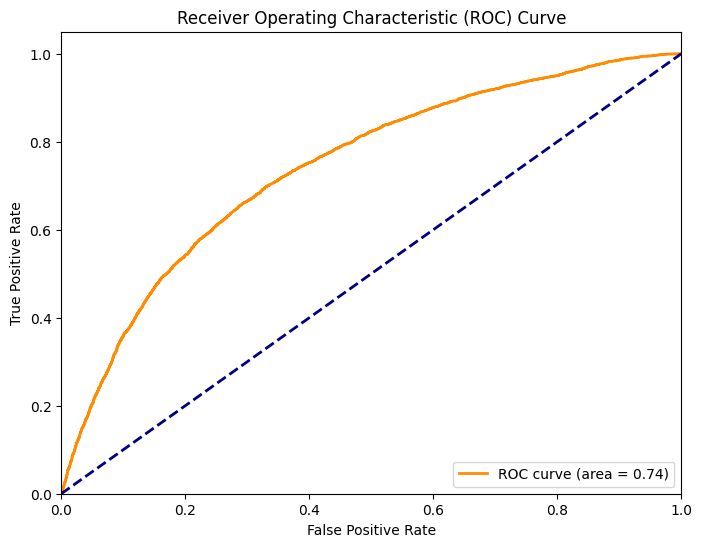

In [255]:
from sklearn.metrics import roc_curve, auc
# ---- Plot ROC Curve for the scikit-learn Logistic Regression Model using selected features ----

# Get predicted probabilities for the positive class using the model "lr" on the selected test set
y_proba_sel = lr.predict_proba(X_test_sel)[:, 1]

# Compute the false positive rate, true positive rate, and thresholds using the reset test labels
fpr, tpr, thresholds = roc_curve(y_test_reset, y_proba_sel)

# Calculate the Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)
print(roc_auc)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Forward seletion with floating backward steps leads to marginally better r-squared by substituting gluc with height

Lasso Log Regression

Best parameter: {'C': 100}
Best cross-validation score: 0.6923383816997418
   param_C  mean_test_score  std_test_score
0    0.001         0.674222        0.003538
1    0.010         0.688551        0.002950
2    0.100         0.691920        0.002764
3    1.000         0.692186        0.002530
4   10.000         0.692300        0.002541
5  100.000         0.692338        0.002521


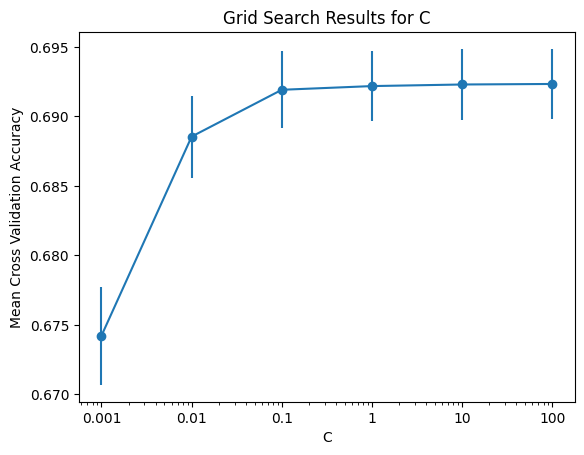

In [256]:
from sklearn.model_selection import GridSearchCV
import matplotlib.ticker as ticker

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

log_reg = LogisticRegression(solver='liblinear', max_iter=1000)

# Set up GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy')

# Fit grid search on the training data
grid_search.fit(X_train, y_train)

# Display the best parameter and best cross-validation score
print("Best parameter:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

results_df = pd.DataFrame(grid_search.cv_results_)

# Display a table of the parameters and scores
print(results_df[['param_C', 'mean_test_score', 'std_test_score']].sort_values('param_C'))

# Plot the mean test score with error bars (using logarithmic scale for C)
plt.errorbar(results_df['param_C'], 
             results_df['mean_test_score'], 
             yerr=results_df['std_test_score'], 
             fmt='-o')
plt.xscale('log')

ax = plt.gca()
# Explicitly set the tick positions and labels
ticks = [0.001, 0.01, 0.1, 1, 10, 100]
ax.set_xticks(ticks)
ax.set_xticklabels(ticks)

plt.xlabel('C')
plt.ylabel('Mean Cross Validation Accuracy')
plt.title('Grid Search Results for C')
plt.show()


        C  Validation Accuracy
0   0.001             0.675421
1   0.010             0.689579
2   0.100             0.691558
3   1.000             0.691558
4  10.000             0.691406
Best C based on validation set: 0.1
Best validation accuracy: 0.6915581944127274


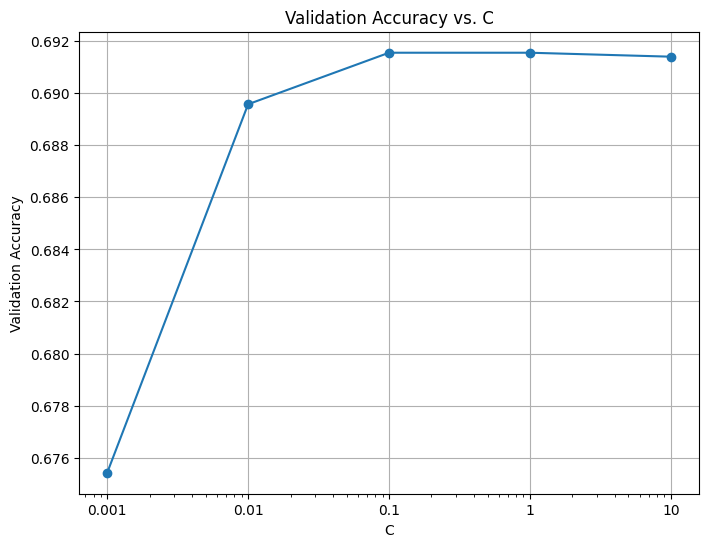

In [257]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Define candidate C values
C_values = [0.001, 0.01, 0.1, 1, 10]
results = []

# Loop through each candidate C value
for C in C_values:
    model = LogisticRegression(solver='liblinear', max_iter=1000, C=C)
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    results.append({'C': C, 'Validation Accuracy': val_accuracy})

# Create a DataFrame with the results
results_df = pd.DataFrame(results)
print(results_df.sort_values('C'))
best_row = results_df.loc[results_df['Validation Accuracy'].idxmax()]
print("Best C based on validation set:", best_row['C'])
print("Best validation accuracy:", best_row['Validation Accuracy'])

# Plot the Validation Accuracy vs. C
plt.figure(figsize=(8, 6))
plt.plot(results_df['C'], results_df['Validation Accuracy'], '-o')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. C')
plt.xticks(C_values, C_values)  # Set ticks to show candidate C values
plt.grid(True)
plt.show()


In [258]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression

# Candidate C values
C_values = [0.001, 0.01, 0.1, 1, 10]

# List to store results
results = []

# Iterate over each C value
for C in C_values:
    # Initialize and fit the L1-penalized logistic regression model
    model = LogisticRegression(penalty='l1', solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    # Get the coefficients and feature names
    coef = model.coef_.flatten()
    features = X_train.columns
    # Identify the features with nonzero coefficients
    selected = features[coef != 0]
    
    results.append({
        'C': C,
        'Number of Selected Features': len(selected),
        'Selected Features': ', '.join(selected)
    })

# Create a DataFrame to display the results
results_df = pd.DataFrame(results)
print(results_df)


        C  Number of Selected Features  \
0   0.001                            5   
1   0.010                            9   
2   0.100                            9   
3   1.000                           10   
4  10.000                           10   

                                   Selected Features  
0  weight, cholesterol, active, age_years, bp_cat...  
1  height, weight, cholesterol, gluc, smoke, alco...  
2  height, weight, cholesterol, gluc, smoke, alco...  
3  gender, height, weight, cholesterol, gluc, smo...  
4  gender, height, weight, cholesterol, gluc, smo...  


In [278]:



log_model_lasso = LogisticRegression(penalty='l1', solver='liblinear', C=0.1)  # C controls regularization strength

# Fit the model on the Training Set
log_model_lasso.fit(X_train, y_train)

# Validation Performance
y_val_pred_lasso = log_model_lasso.predict(X_val)
print("\n=== Validation Accuracy (Lasso) ===", accuracy_score(y_val, y_val_pred_lasso))
print(classification_report(y_val, y_val_pred_lasso))

# Test Performance
y_test_pred_lasso = log_model_lasso.predict(X_test)
print("\n=== Test Accuracy (Lasso) ===", accuracy_score(y_test, y_test_pred_lasso))
print(classification_report(y_test, y_test_pred_lasso))


=== Validation Accuracy (Lasso) === 0.6907969856131537
              precision    recall  f1-score   support

           0       0.70      0.71      0.70      6772
           1       0.68      0.67      0.68      6365

    accuracy                           0.69     13137
   macro avg       0.69      0.69      0.69     13137
weighted avg       0.69      0.69      0.69     13137


=== Test Accuracy (Lasso) === 0.6847313137463845
              precision    recall  f1-score   support

           0       0.69      0.70      0.70      6797
           1       0.67      0.67      0.67      6341

    accuracy                           0.68     13138
   macro avg       0.68      0.68      0.68     13138
weighted avg       0.68      0.68      0.68     13138



In [265]:
# Get Coefficient Importance
feature_importance_lasso = pd.Series(log_model_lasso.coef_[0], index=X_train_df.columns)

# Selected Features (Non-zero Coefficients)
selected_features_lasso = feature_importance_lasso[feature_importance_lasso != 0].index
print("\n=== Selected Features (Lasso) ===")
print(selected_features_lasso)

# Sort and Display Coefficients
print("\n=== Coefficients (Lasso) ===")
print(feature_importance_lasso[selected_features_lasso].sort_values(ascending=False))

X_train_lasso_df = X_train_df[selected_features_lasso].reset_index(drop=True)
X_val_lasso_df = X_val_df[selected_features_lasso].reset_index(drop=True)
X_test_lasso_df = X_test_df[selected_features_lasso].reset_index(drop=True)

y_train_reset = y_train.reset_index(drop=True)
y_val_reset = y_val.reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)




=== Selected Features (Lasso) ===
Index(['height', 'weight', 'cholesterol', 'gluc', 'smoke', 'alco', 'active',
       'age_years', 'bp_category_encoded'],
      dtype='object')

=== Coefficients (Lasso) ===
bp_category_encoded    0.733984
cholesterol            0.580031
age_years              0.386915
weight                 0.241282
height                -0.080058
gluc                  -0.104291
smoke                 -0.104891
alco                  -0.153445
active                -0.218843
dtype: float64


In [275]:
# Add a constant (intercept) term
X_test_lasso_df = sm.add_constant(X_test_lasso_df)

# Fit logistic regression using statsmodels on Test Set
result_test = logit_model_test.fit_regularized(method='l1', alpha=10, L1_wt=1)

# Get the detailed summary for Test Set
print("\n=== Test Set ANOVA Table (Lasso) ===")
print(result_test.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.604150417799911
            Iterations: 75
            Function evaluations: 75
            Gradient evaluations: 75

=== Test Set ANOVA Table (Lasso) ===
                           Logit Regression Results                           
Dep. Variable:                 cardio   No. Observations:                13138
Model:                          Logit   Df Residuals:                    13128
Method:                           MLE   Df Model:                            9
Date:                Sat, 08 Mar 2025   Pseudo R-squ.:                  0.1322
Time:                        22:53:30   Log-Likelihood:                -7896.0
converged:                       True   LL-Null:                       -9098.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------

0.7425599557046432


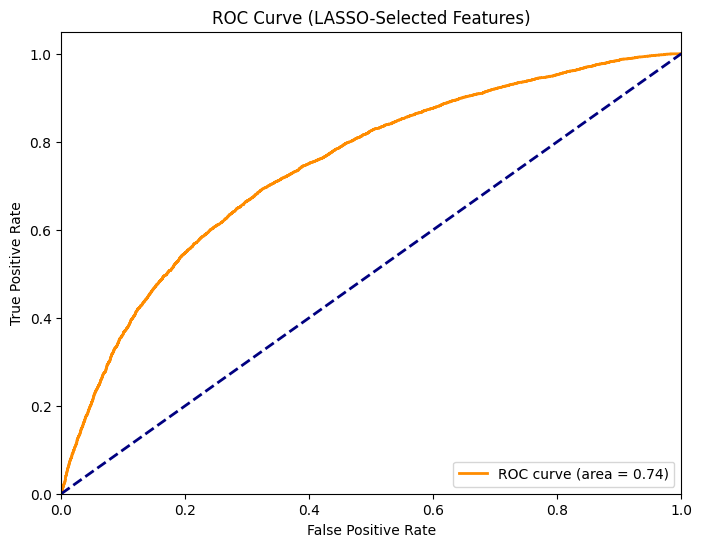

In [276]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities from the statsmodels model on the test set (with constant added)
y_proba_lasso = result_test.predict(X_test_lasso_df)

# Compute the false positive rate, true positive rate, and thresholds
fpr_lasso, tpr_lasso, thresholds_lasso = roc_curve(y_test_reset, y_proba_lasso)

# Calculate the AUC for the LASSO-selected features model
roc_auc_lasso = auc(fpr_lasso, tpr_lasso)
print(roc_auc_lasso)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_lasso, tpr_lasso, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_lasso)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (LASSO-Selected Features)')
plt.legend(loc="lower right")
plt.show()


Baseline model

In [185]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# Define the features and target variable
X = data.drop(columns=['cardio'])  # Drop the target column
y = data['cardio']  # Target column

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the logistic regression model (scikit-learn)
log_reg = LogisticRegression(max_iter=1000, solver='liblinear')

# Train the model on the training set
log_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = log_reg.predict(X_test)

# Evaluate the model
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ---- Statsmodels Part ----

# Convert X_test to a DataFrame if not already and reset the index
X_test_df = pd.DataFrame(X_test, columns=X.columns).reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)

# Add a constant (intercept) term to the test set predictors
X_test_baseline = sm.add_constant(X_test_df)

# Fit logistic regression using statsmodels on the test set using the DataFrame with constant
logit_model_test = sm.Logit(y_test_reset, X_test_baseline)
result_test = logit_model_test.fit()

# Print the detailed summary (ANOVA-like table)
print("\n=== Test Set ANOVA Table (Statsmodels Logit) ===")
print(result_test.summary())


Test Accuracy: 0.6849596590044147

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.70      0.70      6797
           1       0.67      0.67      0.67      6341

    accuracy                           0.68     13138
   macro avg       0.68      0.68      0.68     13138
weighted avg       0.68      0.68      0.68     13138

Optimization terminated successfully.
         Current function value: 0.600834
         Iterations 6

=== Test Set ANOVA Table (Statsmodels Logit) ===
                           Logit Regression Results                           
Dep. Variable:                 cardio   No. Observations:                13138
Model:                          Logit   Df Residuals:                    13127
Method:                           MLE   Df Model:                           10
Date:                Sat, 08 Mar 2025   Pseudo R-squ.:                  0.1324
Time:                        18:38:22   Log-Likelihood:             

With Interaction term height * weight

In [187]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# Define the features and target variable
X = data.drop(columns=['cardio'])  # Drop the target column
y = data['cardio']  # Target column

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the logistic regression model (scikit-learn)
log_reg = LogisticRegression(max_iter=1000, solver='liblinear')

# Train the model on the training set
log_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = log_reg.predict(X_test)

# Evaluate the model
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ---- Statsmodels Part ----

# Convert X_test to a DataFrame if not already and reset the index
X_test_df = pd.DataFrame(X_test, columns=X.columns).reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)

# Create an interaction term of height and weight
# Make sure your data has 'height' and 'weight' columns
X_test_df['height_weight'] = X_test_df['height'] * X_test_df['weight']

# Add a constant (intercept) term to the test set predictors
X_test_baseline = sm.add_constant(X_test_df)

# Fit logistic regression using statsmodels on the test set using the DataFrame with constant
logit_model_test = sm.Logit(y_test_reset, X_test_baseline)
result_test = logit_model_test.fit()

# Print the detailed summary (ANOVA-like table)
print("\n=== Test Set ANOVA Table (Statsmodels Logit with Interaction) ===")
print(result_test.summary())


Test Accuracy: 0.6849596590044147

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.70      0.70      6797
           1       0.67      0.67      0.67      6341

    accuracy                           0.68     13138
   macro avg       0.68      0.68      0.68     13138
weighted avg       0.68      0.68      0.68     13138

Optimization terminated successfully.
         Current function value: 0.600779
         Iterations 6

=== Test Set ANOVA Table (Statsmodels Logit with Interaction) ===
                           Logit Regression Results                           
Dep. Variable:                 cardio   No. Observations:                13138
Model:                          Logit   Df Residuals:                    13126
Method:                           MLE   Df Model:                           11
Date:                Sat, 08 Mar 2025   Pseudo R-squ.:                  0.1325
Time:                        18:42:22   Log-Likelih

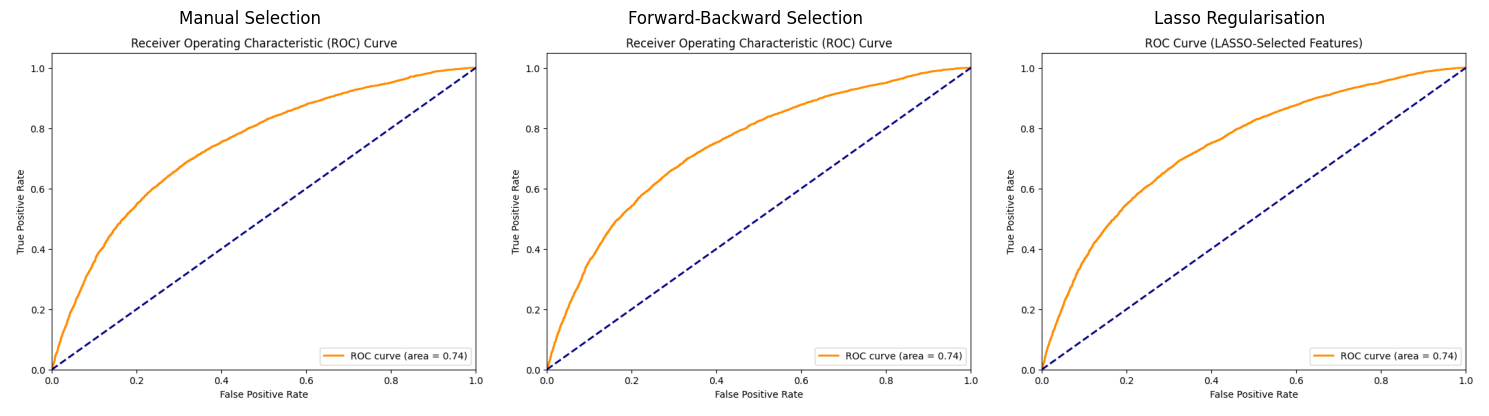

In [282]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Specify paths for each image individually
image1_path = '/Users/timothy/Library/Mobile Documents/com~apple~CloudDocs/school/BT4240/ROC manual.png'
image2_path = '/Users/timothy/Library/Mobile Documents/com~apple~CloudDocs/school/BT4240/ROC selected.png'
image3_path = '/Users/timothy/Library/Mobile Documents/com~apple~CloudDocs/school/BT4240/ROC Lasso.png'

# Read the images
img1 = mpimg.imread(image1_path)
img2 = mpimg.imread(image2_path)
img3 = mpimg.imread(image3_path)

# Create a 1 row x 3 columns subplot grid
fig, axes = plt.subplots(1, 3, figsize=(15, 10))

# Display each image in its respective subplot
axes[0].imshow(img1)
axes[0].set_title('Manual Selection')
axes[0].axis('off')

axes[1].imshow(img2)
axes[1].set_title('Forward-Backward Selection')
axes[1].axis('off')

axes[2].imshow(img3)
axes[2].set_title('Lasso Regularisation')
axes[2].axis('off')

plt.tight_layout()
plt.show()


Trainign with pulse_pressure

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
datapp = pd.read_csv('Pulse pressure.csv')
datapp.head()

,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bp_category_encoded,pulse_pressure
0,1,0.463125,-0.873002,-1.043394,-0.097473,1,1,0,0,1,0,-0.412905,2,-1.392349
1,0,-1.107092,0.933963,0.965018,1.058002,3,1,0,0,1,1,0.325344,3,0.496634
2,0,0.070571,-0.715875,0.295547,-1.252948,3,1,0,0,0,1,-0.265255,2,1.441125
3,1,0.593977,0.698272,1.634488,2.213477,1,1,0,0,1,1,-0.708204,3,0.496634
4,0,-1.107092,-1.344384,-1.712865,-2.408423,1,1,0,0,0,0,-0.855854,0,-0.447858


In [ ]:
from sklearn.model_selection import train_test_split

X = datapp.drop(columns=['cardio'])  # Drop the target column
y = datapp['cardio']  # Keep only the target column

# 60/20/20 train/val/test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify = y, random_state=4240)  # 60% train, 40% temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify = y_temp, random_state=4240)  # 20% val, 20% test

print("Train Shape:", X_train.shape)
print("Validation Shape:", X_val.shape)
print("Test Shape:", X_test.shape)

Train Shape: (39411, 13)
Validation Shape: (13137, 13)
Test Shape: (13138, 13)


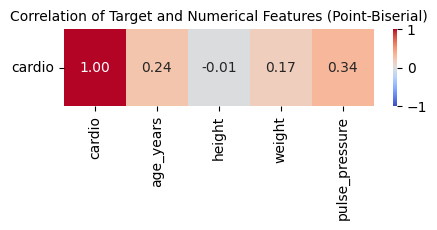

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr

# List of numerical features, including 'cardio'
numerical_features = ['cardio', 'age_years', 'height', 'weight', 'pulse_pressure']

# Compute the correlation matrix using the default (Pearson) method
correlation_matrix = datapp[numerical_features].corr()

# Overwrite the correlations for 'cardio' vs each other numerical variable with point-biserial coefficients
for feature in numerical_features:
    if feature != 'cardio':
        pb_corr = pointbiserialr(datapp['cardio'], datapp[feature])[0]
        correlation_matrix.loc['cardio', feature] = pb_corr
        correlation_matrix.loc[feature, 'cardio'] = pb_corr

cardio_corr = correlation_matrix.loc[['cardio']]

# Plot the updated correlation matrix
plt.figure(figsize=(5, 1))
ax = sns.heatmap(cardio_corr, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation of Target and Numerical Features (Point-Biserial)", fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.show()

In [10]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import statsmodels.api as sm


data_manual_modelpp = datapp.drop(columns=['height', 'gender', 'smoke', 'alco','ap_hi','ap_lo'])

# Train the logistic regression model using scikit-learn on the training set
manual_modelpp = LogisticRegression()
manual_modelpp.fit(X_train, y_train)

# Evaluate on the validation set
manual_y_val_predpp = manual_modelpp.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, manual_y_val_predpp))
print("\nValidation Classification Report:")
print(classification_report(y_val, manual_y_val_predpp))

# Evaluate on the test set
manual_y_test_predpp = manual_modelpp.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, manual_y_test_predpp))
print("\nTest Classification Report:")
print(classification_report(y_test, manual_y_test_predpp))

# ----- Statsmodels: ANOVA-like table and Odds Ratios on Test Set -----

X_test_manualpp = X_test.drop(columns=['height', 'gender', 'smoke', 'alco','ap_hi','ap_lo']).reset_index(drop=True)
y_test_resetpp = y_test.reset_index(drop=True)

# Add a constant (intercept) term to the test set predictors
X_test_manual_dfpp = sm.add_constant(X_test_manualpp)

# Fit logistic regression using statsmodels on the test set
logit_model_testpp = sm.Logit(y_test_resetpp, X_test_manual_dfpp)
result_testpp = logit_model_testpp.fit()

# Print the detailed summary for the test set (ANOVA-like table)
print("\n=== Test Set ANOVA Table (Manual Selection) ===")
print(result_testpp.summary())

# Calculate and print the Odds Ratios for the test set
odds_ratios_test = pd.Series(np.exp(result_testpp.params), index=X_test_manual_dfpp.columns)
print("\n=== Test Set Odds Ratios ===")
print(odds_ratios_test)


Validation Accuracy: 0.7217020628758468

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.79      0.75      6772
           1       0.74      0.65      0.69      6365

    accuracy                           0.72     13137
   macro avg       0.72      0.72      0.72     13137
weighted avg       0.72      0.72      0.72     13137

Test Accuracy: 0.7259856903638301

Test Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.80      0.75      6772
           1       0.75      0.65      0.70      6366

    accuracy                           0.73     13138
   macro avg       0.73      0.72      0.72     13138
weighted avg       0.73      0.73      0.72     13138

Optimization terminated successfully.
         Current function value: 0.568100
         Iterations 6

=== Test Set ANOVA Table (Manual Selection) ===
                           Logit Regression Results      